Outcome variables:

- depression
- anxiety
- parenting stress

Confounders

- mental health treatment
- Child level variables
    - expressive language
    - ADOS
- DAS (relationships)

Start with time 1 versus time 3
- finished at least 10 sessions (`finish_tx`)

Similar age and location of kids

In [11]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context='notebook', style='ticks')

In [2]:
mbsr_raw = pd.read_csv('../data/MBSR Data Set 3-28-18 for analysis.csv', index_col=0, na_values=[' '],
                       parse_dates=['child_dob', 'ados_date', 'startdate'])
mbsr_raw.tail()

,finish_tx,parentfinish_t6,childfinish_t6,child_dob,ados_date,age_ados,ados_module,ados_new_algorithm,ados_severity,ados_concern,...,DescribeT5,AwareT5,NonjudgeT5,NonreactT5,FFMQT6,ObserveT6,DescribeT6,AwareT6,NonjudgeT6,NonreactT6
study_id,,,,,,,,,,,,,,,,,,,,,
59,1,1.0,1,2015-05-07,2017-04-04,1.91,3.0,17.0,NaN,3.0,...,NaN,NaN,NaN,NaN,126.0,16.0,33.0,28.0,29.0,20.0
60,1,0.0,1,2015-02-17,2017-04-21,2.17,3.0,26.0,NaN,3.0,...,26.0,33.0,28.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN
61,0,0.0,0,2014-10-20,2017-04-22,2.51,3.0,17.0,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,1,1.0,1,2014-12-06,2017-05-22,2.46,3.0,18.0,NaN,3.0,...,25.0,32.0,32.0,14.0,117.0,19.0,21.0,28.0,33.0,16.0
63,1,1.0,1,2015-03-19,2017-06-26,2.27,3.0,22.0,NaN,3.0,...,27.0,32.0,33.0,17.0,131.0,29.0,24.0,31.0,32.0,15.0


Find the first column label for outcomes

In [3]:
outcome_start = np.argwhere(mbsr_raw.columns=='cbcl1t6').squeeze()

Extract columns to be used in analysis

In [4]:
mbsr_raw.columns[mbsr_raw.columns.str.contains('str')].tolist()

[]

In [5]:
columns_to_keep = (['finish_tx', 'age_ados', 'ados_new_algorithm', 'group_', 
                    'startdate', 'age_begin', 'expressiveraw'] 
                   + mbsr_raw.columns[outcome_start:].tolist())
mbsr_data = mbsr_raw[columns_to_keep].copy()
mbsr_data.head()

,finish_tx,age_ados,ados_new_algorithm,group_,startdate,age_begin,expressiveraw,cbcl1t6,cbcl2t6,cbcl3t6,...,DescribeT5,AwareT5,NonjudgeT5,NonreactT5,FFMQT6,ObserveT6,DescribeT6,AwareT6,NonjudgeT6,NonreactT6
study_id,,,,,,,,,,,,,,,,,,,,,
1,1,2.46,14.0,1,2015-04-02,2.52,19.0,0.0,50.0,50.0,...,31.0,39.0,29.0,17.0,133.0,16.0,31.0,40.0,31.0,15.0
2,1,2.94,12.0,1,2015-04-02,2.52,47.0,1.0,50.0,50.0,...,37.0,32.0,36.0,20.0,NaN,16.0,36.0,34.0,NaN,16.0
3,1,2.82,24.0,0,2015-04-02,2.86,34.0,3.0,55.0,69.0,...,25.0,32.0,36.0,20.0,126.0,12.0,21.0,31.0,36.0,26.0
4,1,2.49,24.0,1,2015-05-01,2.57,13.0,1.0,50.0,50.0,...,35.0,40.0,36.0,21.0,165.0,30.0,35.0,40.0,35.0,25.0
5,1,2.52,20.0,1,2015-05-08,2.55,12.0,2.0,51.0,54.0,...,22.0,32.0,31.0,13.0,122.0,22.0,22.0,33.0,32.0,13.0


In [6]:
mbsr_data.shape

(63, 152)

Create columns for change in outcome

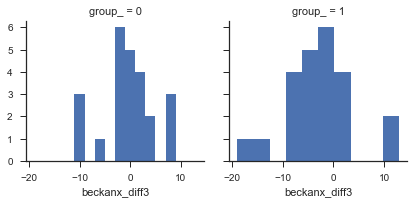

In [13]:
mbsr_data['beckanx_diff3'] = mbsr_data['beckanxT3'] - mbsr_data['beckanxT1']
g = sns.FacetGrid(mbsr_data, col='group_')
g.map(plt.hist, 'beckanx_diff3');

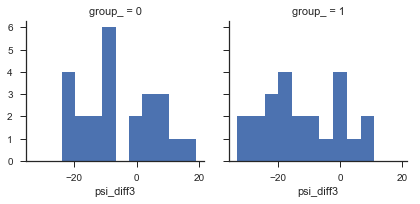

In [14]:
mbsr_data['psi_diff3'] = mbsr_data['psitot3'] - mbsr_data['psitot']
g = sns.FacetGrid(mbsr_data, col='group_')
g.map(plt.hist, 'psi_diff3');

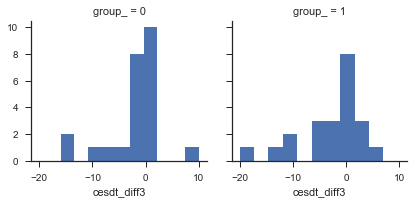

In [15]:
mbsr_data['cesdt_diff3'] = mbsr_data['cesdt3'] - mbsr_data['cesdt1']
g = sns.FacetGrid(mbsr_data, col='group_')
g.map(plt.hist, 'cesdt_diff3');

## Model specification

In [ ]:
def create_outcome_model(outcome):
    
    with pm.Model() as mod:
        
        
        
    return mod